In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
root_path = os.path.abspath('./..')
sys.path.insert(0, root_path )

import itertools
import functools
from tqdm import tqdm

import pandas as pd
import numpy as np
import numba
import sklearn
import sklearn.linear_model
import sklearn.cluster
import sklearn.metrics
import matplotlib.pyplot as plt

import hiddensc
from hiddensc import utils, files, vis
import seaborn as sns

import scanpy as sc
import scvi
import anndata
#from . import mixscape

utils.set_random_seed(utils.RANDOM_SEED)
utils.print_module_versions([sc, anndata, scvi, hiddensc])
vis.visual_settings()

Global seed set to 0


Random seed set to 42
scanpy              : 1.9.3
anndata             : 0.8.0
scvi                : 0.20.3
hiddensc            : beta_25.03.23


In [70]:
import glob

pred_files = list(glob.glob('../results/naiveB_1900_memoryB_100/*predictions.csv'))

dirname = '../results/naiveB_1900_memoryB_100/'

def _read_prediction_csv(fname:str) -> pd.DataFrame:
    """Predictions have a special header + index, so we have a helper function."""
    files.check_ext(fname, 'csv')
    return pd.read_csv(fname, index_col=[0], header=[0, 1, 2])


dfs = [_read_prediction_csv(fname) for fname in glob.glob(os.path.join(dirname, '*predictions.csv'))]
pred_df = pd.concat(dfs, axis=1)
pred_df

PCA                      batch  \
                             Mixscape         Unnamed: 1_level_1   
                                p_hat p_label               Case   
barcodes                                                           
naiveB_a_AAACCTGCACGGTAGA-1     0.000   0.000              1.000   
naiveB_a_AAACCTGCAGATGGGT-1     0.000   0.000              1.000   
naiveB_a_AAAGATGCATTTCAGG-1     0.000   1.000              0.000   
naiveB_a_AAAGCAAAGCCAACAG-1     0.000   1.000              0.000   
naiveB_a_AAAGCAAAGTGCCATT-1     0.000   0.000              1.000   
...                               ...     ...                ...   
memoryB_b_TGTCCCATCCTTTACA-1    0.000   0.000              1.000   
memoryB_b_TTGACTTAGCTTTGGT-1    0.000   0.000              1.000   
memoryB_b_TTGCCGTAGGCGTACA-1    0.000   0.000              1.000   
memoryB_b_TTTGCGCTCTACTATC-1    0.000   0.000              1.000   
memoryB_b_TTTGGTTGTTTGTGTG-1    0.000   0.000              1.000   

                                      perturbed      PCA                \
                             Unnamed: 2_level_1 Logistic           SVM   
                                       Memory B    p_hat p_label p_hat   
barcodes                                                                 
naiveB_a_AAACCTGCACGGTAGA-1               0.000    0.564   1.000 0.568   
naiveB_a_AAACCTGCAGATGGGT-1               0.000    0.406   0.000 0.442   
naiveB_a_AAAGATGCATTTCAGG-1               0.000    0.369   0.000 0.439   
naiveB_a_AAAGCAAAGCCAACAG-1               0.000    0.496   0.000 0.494   
naiveB_a_AAAGCAAAGTGCCATT-1               0.000    0.489   0.000 0.488   
...                                         ...      ...     ...   ...   
memoryB_b_TGTCCCATCCTTTACA-1              1.000    0.688   1.000 0.568   
memoryB_b_TTGACTTAGCTTTGGT-1              1.000    0.927   1.000 0.725   
memoryB_b_TTGCCGTAGGCGTACA-1              1.000    0.792   1.000 0.599   
memoryB_b_TTTGCGCTCTACTATC-1              1.000    0.703   1.000 0.567   
memoryB_b_TTTGGTTGTTTGTGTG-1              1.000    0.783   1.000 0.616   

                                     LinearSCVI_10          ... SCVI_10  \
                                          Logistic          ...     SVM   
                             p_label         p_hat p_label  ...   p_hat   
barcodes                                                    ...           
naiveB_a_AAACCTGCACGGTAGA-1    1.000         0.490   0.000  ...   0.458   
naiveB_a_AAACCTGCAGATGGGT-1    0.000         0.538   0.000  ...   0.424   
naiveB_a_AAAGATGCATTTCAGG-1    0.000         0.411   0.000  ...   0.483   
naiveB_a_AAAGCAAAGCCAACAG-1    0.000         0.442   0.000  ...   0.500   
naiveB_a_AAAGCAAAGTGCCATT-1    0.000         0.502   0.000  ...   0.459   
...                              ...           ...     ...  ...     ...   
memoryB_b_TGTCCCATCCTTTACA-1   1.000         0.689   1.000  ...   0.468   
memoryB_b_TTGACTTAGCTTTGGT-1   1.000         0.740   1.000  ...   0.609   
memoryB_b_TTGCCGTAGGCGTACA-1   1.000         0.745   1.000  ...   0.550   
memoryB_b_TTTGCGCTCTACTATC-1   1.000         0.696   1.000  ...   0.641   
memoryB_b_TTTGGTTGTTTGTGTG-1   1.000         0.723   1.000  ...   0.591   

                                      SCVI_25                        SCVI_50  \
                                     Logistic           SVM         Logistic   
                             p_label    p_hat p_label p_hat p_label    p_hat   
barcodes                                                                       
naiveB_a_AAACCTGCACGGTAGA-1    0.000    0.487   0.000 0.500   0.000    0.464   
naiveB_a_AAACCTGCAGATGGGT-1    0.000    0.467   0.000 0.490   0.000    0.469   
naiveB_a_AAAGATGCATTTCAGG-1    0.000    0.466   0.000 0.491   0.000    0.363   
naiveB_a_AAAGCAAAGCCAACAG-1    0.000    0.463   0.000 0.493   0.000    0.400   
naiveB_a_AAAGCAAAGTGCCATT-1    0.000    0.469   0.000 0.490   0.000    0.543   
...                              ...      ...     ...   

In [83]:
dfs = [_read_prediction_csv(fname) for fname in glob.glob(os.path.join(dirname, '*predictions.csv'))]
pred_df = pd.concat(dfs, axis=1)
cols = pred_df.columns.tolist()
values = {}
for label in ['batch', 'perturbed']:
    is_col = np.array([label in c[0] for c in cols])
    assert np.sum(is_col) == 1, f'Expected at least one {label} column, found {np.sum(is_col)}'
    index = np.argmax(is_col)
    values[label] = pred_df[cols[index]].values
    pred_df.drop(cols[index], axis=1, inplace=True)
    


{'batch': array([1., 1., 0., ..., 1., 1., 1.]),
 'perturbed': array([0., 0., 0., ..., 1., 1., 1.])}

In [56]:
fname = '../results/naiveB_1900_memoryB_100/predictions.csv'
pred_df = pd.read_csv(fname, index_col=[0], header=[0, 1, 2])
a_df = pd.read_csv('../results/naiveB_1900_memoryB_100/mixscape_predictions.csv', index_col=[0], header=[0, 1, 2])
pred_df

batch          perturbed      PCA  \
                             Unnamed: 1_level_1 Unnamed: 2_level_1 Logistic   
                                           Case           Memory B    p_hat   
barcodes                                                                      
naiveB_a_AAACCTGCACGGTAGA-1               1.000              0.000    0.564   
naiveB_a_AAACCTGCAGATGGGT-1               1.000              0.000    0.406   
naiveB_a_AAAGATGCATTTCAGG-1               0.000              0.000    0.369   
naiveB_a_AAAGCAAAGCCAACAG-1               0.000              0.000    0.496   
naiveB_a_AAAGCAAAGTGCCATT-1               1.000              0.000    0.489   
...                                         ...                ...      ...   
memoryB_b_TGTCCCATCCTTTACA-1              1.000              1.000    0.688   
memoryB_b_TTGACTTAGCTTTGGT-1              1.000              1.000    0.927   
memoryB_b_TTGCCGTAGGCGTACA-1              1.000              1.000    0.792   
memoryB_b_TTTGCGCTCTACTATC-1              1.000              1.000    0.703   
memoryB_b_TTTGGTTGTTTGTGTG-1              1.000              1.000    0.783   

                                                   LinearSCVI_10          \
                                       SVM              Logistic           
                             p_label p_hat p_label         p_hat p_label   
barcodes                                                                   
naiveB_a_AAACCTGCACGGTAGA-1    1.000 0.568   1.000         0.490   0.000   
naiveB_a_AAACCTGCAGATGGGT-1    0.000 0.442   0.000         0.538   0.000   
naiveB_a_AAAGATGCATTTCAGG-1    0.000 0.439   0.000         0.411   0.000   
naiveB_a_AAAGCAAAGCCAACAG-1    0.000 0.494   0.000         0.442   0.000   
naiveB_a_AAAGCAAAGTGCCATT-1    0.000 0.488   0.000         0.502   0.000   
...                              ...   ...     ...           ...     ...   
memoryB_b_TGTCCCATCCTTTACA-1   1.000 0.568   1.000         0.689   1.000   
memoryB_b_TTGACTTAGCTTTGGT-1   1.000 0.725   1.000         0.740   1.000   
memoryB_b_TTGCCGTAGGCGTACA-1   1.000 0.599   1.000         0.745   1.000   
memoryB_b_TTTGCGCTCTACTATC-1   1.000 0.567   1.000         0.696   1.000   
memoryB_b_TTTGGTTGTTTGTGTG-1   1.000 0.616   1.000         0.723   1.000   

                                            ... SCVI_10          SCVI_25  \
                               SVM          ...     SVM         Logistic   
                             p_hat p_label  ...   p_hat p_label    p_hat   
barcodes                                    ...                            
naiveB_a_AAACCTGCACGGTAGA-1  0.520   0.000  ...   0.458   0.000    0.487   
naiveB_a_AAACCTGCAGATGGGT-1  0.537   1.000  ...   0.424   0.000    0.467   
naiveB_a_AAAGATGCATTTCAGG-1  0.447   0.000  ...   0.483   0.000    0.466   
naiveB_a_AAAGCAAAGCCAACAG-1  0.452   0.000  ...   0.500   0.000    0.463   
naiveB_a_AAAGCAAAGTGCCATT-1  0.495   0.000  ...   0.459   0.000    0.469   
...                            ...     ...  ...     ...     ...      ...   
memoryB_b_TGTCCCATCCTTTACA-1 0.609   1.000  ...   0.468   0.000    0.515   
memoryB_b_TTGACTTAGCTTTGGT-1 0.631   1.000  ...   0.609   1.000    0.581   
memoryB_b_TTGCCGTAGGCGTACA-1 0.651   1.000  ...   0.550   1.000    0.649   
memoryB_b_TTTGCGCTCTACTATC-1 0.609   1.000  ...   0.641   1.000    0.631   
memoryB_b_TTTGGTTGTTTGTGTG-1 0.630   1.000  ...   0.591   1.000    0.675   

                                                    SCVI_50                \
                                       SVM         Logistic           SVM   
                             p_label p_hat p_label    p_hat p_label p_hat   
barcodes                                                                    
naiveB_a_AAACCTGCACGGTAGA-1    0.000 0.500   0.000    0.464   0.000 0.490   
naiveB_a_AAACCTGCAGATGGGT-1    0.000 0.490   0.000    0.469   0.000 0.491   
naiveB_a_AAAGATGCATTTCAGG-1    0.000 0.491   0.000    0.363   0.000 0.460   
naiveB_a_AAAGCAAAGCCAACAG-1    0.00

In [62]:
b_df

batch          perturbed      PCA  \
                             Unnamed: 1_level_1 Unnamed: 2_level_1 Logistic   
                                           Case           Memory B    p_hat   
barcodes                                                                      
naiveB_a_AAACCTGCACGGTAGA-1               1.000              0.000    0.564   
naiveB_a_AAACCTGCAGATGGGT-1               1.000              0.000    0.406   
naiveB_a_AAAGATGCATTTCAGG-1               0.000              0.000    0.369   
naiveB_a_AAAGCAAAGCCAACAG-1               0.000              0.000    0.496   
naiveB_a_AAAGCAAAGTGCCATT-1               1.000              0.000    0.489   
...                                         ...                ...      ...   
memoryB_b_TGTCCCATCCTTTACA-1              1.000              1.000    0.688   
memoryB_b_TTGACTTAGCTTTGGT-1              1.000              1.000    0.927   
memoryB_b_TTGCCGTAGGCGTACA-1              1.000              1.000    0.792   
memoryB_b_TTTGCGCTCTACTATC-1              1.000              1.000    0.703   
memoryB_b_TTTGGTTGTTTGTGTG-1              1.000              1.000    0.783   

                                                   LinearSCVI_10          \
                                       SVM              Logistic           
                             p_label p_hat p_label         p_hat p_label   
barcodes                                                                   
naiveB_a_AAACCTGCACGGTAGA-1    1.000 0.568   1.000         0.490   0.000   
naiveB_a_AAACCTGCAGATGGGT-1    0.000 0.442   0.000         0.538   0.000   
naiveB_a_AAAGATGCATTTCAGG-1    0.000 0.439   0.000         0.411   0.000   
naiveB_a_AAAGCAAAGCCAACAG-1    0.000 0.494   0.000         0.442   0.000   
naiveB_a_AAAGCAAAGTGCCATT-1    0.000 0.488   0.000         0.502   0.000   
...                              ...   ...     ...           ...     ...   
memoryB_b_TGTCCCATCCTTTACA-1   1.000 0.568   1.000         0.689   1.000   
memoryB_b_TTGACTTAGCTTTGGT-1   1.000 0.725   1.000         0.740   1.000   
memoryB_b_TTGCCGTAGGCGTACA-1   1.000 0.599   1.000         0.745   1.000   
memoryB_b_TTTGCGCTCTACTATC-1   1.000 0.567   1.000         0.696   1.000   
memoryB_b_TTTGGTTGTTTGTGTG-1   1.000 0.616   1.000         0.723   1.000   

                                            ...  SCVI_25                \
                               SVM          ... Logistic           SVM   
                             p_hat p_label  ...    p_hat p_label p_hat   
barcodes                                    ...                          
naiveB_a_AAACCTGCACGGTAGA-1  0.520   0.000  ...    0.487   0.000 0.500   
naiveB_a_AAACCTGCAGATGGGT-1  0.537   1.000  ...    0.467   0.000 0.490   
naiveB_a_AAAGATGCATTTCAGG-1  0.447   0.000  ...    0.466   0.000 0.491   
naiveB_a_AAAGCAAAGCCAACAG-1  0.452   0.000  ...    0.463   0.000 0.493   
naiveB_a_AAAGCAAAGTGCCATT-1  0.495   0.000  ...    0.469   0.000 0.490   
...                            ...     ...  ...      ...     ...   ...   
memoryB_b_TGTCCCATCCTTTACA-1 0.609   1.000  ...    0.515   0.000 0.500   
memoryB_b_TTGACTTAGCTTTGGT-1 0.631   1.000  ...    0.581   1.000 0.516   
memoryB_b_TTGCCGTAGGCGTACA-1 0.651   1.000  ...    0.649   1.000 0.532   
memoryB_b_TTTGCGCTCTACTATC-1 0.609   1.000  ...    0.631   1.000 0.527   
memoryB_b_TTTGGTTGTTTGTGTG-1 0.630   1.000  ...    0.675   1.000 0.539   

                                      SCVI_50                            PCA  \
                                     Logistic           SVM         Mixscape   
                             p_label    p_hat p_label p_hat p_label    p_hat   
barcodes                                                                       
naiveB_a_AAACCTGCACGGTAGA-1    0.000    0.464   0.000 0.490   0.000    0.000   
naiveB_a_AAACCTGCAGATGGGT-1    0.000    0.469   0.000 0.491   0.000    0.000   
naiveB_a_AAAGATGCATTTCAGG-1    0.000    0.363   0.000 0.460   0.000    0.000   
naiveB_a_AAAGCAAAGCCAACAG-1    0.000    0.40

In [61]:
b_df = pd.concat((pred_df, a_df), axis=1)

# Load data

In [3]:
OVERWRITE = True

In [42]:
utils.set_random_seed(utils.RANDOM_SEED)
exp_id = files.MEMORY_B_VALUES[0]
# Check and setup files.
data_name = f'naiveB_1900_memoryB_{exp_id:d}'
at_results_dir = functools.partial(os.path.join, root_path, files.RESULT_DIR, data_name)
if not os.path.exists(at_results_dir('dim_reduced.npz')):
    print(f'Did not find features file for {data_name}')

if os.path.exists(at_results_dir('predictions.csv')) and not OVERWRITE:
    print(f'Skipping {data_name}, found outputs and overwrite={OVERWRITE}')

# Load dataset.
main_datafile = os.path.join(root_path, files.DATA_DIR, f'{data_name}_raw.h5ad')
adata = sc.read(main_datafile)
adata.X = adata.layers['counts']
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset=True)

Random seed set to 42


In [43]:
"""Pertpy's implementation of Mixscape.

We have this custom module since the current github repo version is 0.4 but it breaks.
Pip is 0.3 but is not as flexible as wee need for our comparison.
Source reference: https://github.com/theislab/pertpy/blob/development/pertpy/tools/_mixscape.py
Pertpy's liscence is MIT (https://github.com/theislab/pertpy/blob/development/LICENSE)
"""

from __future__ import annotations

import warnings

import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from pynndescent import NNDescent
from rich import print
from scanpy.tools._utils import _choose_representation
from scipy import sparse
from scipy.sparse import csr_matrix, issparse, spmatrix
from sklearn.mixture import GaussianMixture


warnings.simplefilter("ignore")


class Mixscape:
    """Python implementation of Mixscape."""

    def __init__(self):
        pass

    def perturbation_signature(
        self,
        adata: AnnData,
        pert_key: str,
        control: str,
        split_by: str | None = None,
        n_neighbors: int = 20,
        use_rep: str | None = None,
        n_pcs: int | None = None,
        batch_size: int | None = None,
        copy: bool = False,
        **kwargs,
    ):
        """Calculate perturbation signature.

        For each cell, we identify `n_neighbors` cells from the control pool with the most similar mRNA expression profiles.
        The perturbation signature is calculated by subtracting the averaged mRNA expression profile of the control
        neighbors from the mRNA expression profile of each cell.

        Args:
            adata: The annotated data object.
            pert_key: The column  of `.obs` with perturbation categories, should also contain `control`.
            control: Control category from the `pert_key` column.
            split_by: Provide the column `.obs` if multiple biological replicates exist to calculate
                the perturbation signature for every replicate separately.
            n_neighbors: Number of neighbors from the control to use for the perturbation signature.
            use_rep: Use the indicated representation. `'X'` or any key for `.obsm` is valid.
                If `None`, the representation is chosen automatically:
                For `.n_vars` < 50, `.X` is used, otherwise 'X_pca' is used.
                If 'X_pca' is not present, it’s computed with default parameters.
            n_pcs: Use this many PCs. If `n_pcs==0` use `.X` if `use_rep is None`.
            batch_size: Size of batch to calculate the perturbation signature.
                If 'None', the perturbation signature is calcuated in the full mode, requiring more memory.
                The batched mode is very inefficient for sparse data.
            copy: Determines whether a copy of the `adata` is returned.
            **kwargs: Additional arguments for the `NNDescent` class from `pynndescent`.

        Returns:
            If `copy=True`, returns the copy of `adata` with the perturbation signature in `.layers["X_pert"]`.
            Otherwise writes the perturbation signature directly to `.layers["X_pert"]` of the provided `adata`.
        """
        if copy:
            adata = adata.copy()

        adata.layers["X_pert"] = adata.X.copy()

        control_mask = adata.obs[pert_key] == control

        if split_by is None:
            split_masks = [np.full(adata.n_obs, True, dtype=bool)]
        else:
            split_obs = adata.obs[split_by]
            cats = split_obs.unique()
            split_masks = [split_obs == cat for cat in cats]

        R = _choose_representation(adata, use_rep=use_rep, n_pcs=n_pcs)

        for split_mask in split_masks:
            control_mask_split = control_mask & split_mask

            R_split = R[split_mask]
            R_control = R[control_mask_split]

            eps = kwargs.pop("epsilon", 0.1)
            nn_index = NNDescent(R_control, **kwargs)
            indices, _ = nn_index.query(R_split, k=n_neighbors, epsilon=eps)

            X_control = np.expm1(adata.X[control_mask_split])

            n_split = split_mask.sum()
            n_control = X_control.shape[0]

            if batch_size is None:
                col_indices = np.ravel(indices)
                row_indices = np.repeat(np.arange(n_split), n_neighbors)

                neigh_matrix = csr_matrix(
                    (np.ones_like(col_indices, dtype=np.float64), (row_indices, col_indices)),
                    shape=(n_split, n_control),
                )
                neigh_matrix /= n_neighbors
                adata.layers["X_pert"][split_mask] -= np.log1p(neigh_matrix @ X_control)
            else:
                is_sparse = issparse(X_control)
                split_indices = np.where(split_mask)[0]
                for i in range(0, n_split, batch_size):
                    size = min(i + batch_size, n_split)
                    select = slice(i, size)

                    batch = np.ravel(indices[select])
                    split_batch = split_indices[select]

                    size = size - i

                    # sparse is very slow
                    means_batch = X_control[batch]
                    means_batch = means_batch.toarray() if is_sparse else means_batch
                    means_batch = means_batch.reshape(size, n_neighbors, -1).mean(1)

                    adata.layers["X_pert"][split_batch] -= np.log1p(means_batch)

        if copy:
            return adata

    def mixscape(
        self,
        adata: AnnData,
        labels: str,
        control: str,
        new_class_name: str | None = "mixscape_class",
        min_de_genes: int | None = 5,
        layer: str | None = None,
        logfc_threshold: float | None = 0.25,
        iter_num: int | None = 10,
        split_by: str | None = None,
        pval_cutoff: float | None = 5e-2,
        perturbation_type: str | None = "KO",
        copy: bool | None = False,
    ):
        """Identify perturbed and non-perturbed gRNA expressing cells that accounts for multiple treatments/conditions/chemical perturbations.

        The implementation resembles https://satijalab.org/seurat/reference/runmixscape

        Args:
            adata: The annotated data object.
            pert_key: The column of `.obs` with perturbation categories, should also contain `control`.
            labels: The column of `.obs` with target gene labels.
            control: Control category from the `pert_key` column.
            new_class_name: Name of mixscape classification to be stored in `.obs`.
            min_de_genes: Required number of genes that are differentially expressed for method to separate perturbed and non-perturbed cells.
            layer: Key from adata.layers whose value will be used to perform tests on. Default is using `.layers["X_pert"]`.
            logfc_threshold: Limit testing to genes which show, on average, at least X-fold difference (log-scale) between the two groups of cells (default: 0.25).
            iter_num: Number of normalmixEM iterations to run if convergence does not occur.
            split_by: Provide the column `.obs` if multiple biological replicates exist to calculate
                    the perturbation signature for every replicate separately.
            pval_cutoff: P-value cut-off for selection of significantly DE genes.
            perturbation_type: specify type of CRISPR perturbation expected for labeling mixscape classifications. Defaults to KO.
            copy: Determines whether a copy of the `adata` is returned.

        Returns:
            If `copy=True`, returns the copy of `adata` with the classification result in `.obs`.
            Otherwise writes the results directly to `.obs` of the provided `adata`.

            mixscape_class: pandas.Series (`adata.obs['mixscape_class']`).
            Classification result with cells being either classified as perturbed (KO, by default) or non-perturbed (NP) based on their target gene class.

            mixscape_class_global: pandas.Series (`adata.obs['mixscape_class_global']`).
            Global classification result (perturbed, NP or NT)

            mixscape_class_p_ko: pandas.Series (`adata.obs['mixscape_class_p_ko']`).
            Posterior probabilities used to determine if a cell is KO (default).
            Name of this item will change to match perturbation_type parameter setting. (>0.5) or NP
        """
        if copy:
            adata = adata.copy()

        if split_by is None:
            split_masks = [np.full(adata.n_obs, True, dtype=bool)]
            categories = ["all"]
        else:
            split_obs = adata.obs[split_by]
            categories = split_obs.unique()
            split_masks = [split_obs == category for category in categories]

        perturbation_markers = self._get_perturbation_markers(
            adata, split_masks, categories, labels, control, layer, pval_cutoff, min_de_genes, logfc_threshold
        )

        adata_comp = adata
        if layer is not None:
            X = adata_comp.layers[layer]
        else:
            try:
                X = adata_comp.layers["X_pert"]
            except KeyError:
                print(
                    '[bold yellow]No "X_pert" found in .layers! -- Please run pert_sign first to calculate perturbation signature!'
                )
                raise
        # initialize return variables
        adata.obs[f"{new_class_name}_p_{perturbation_type.lower()}"] = 0
        adata.obs[new_class_name] = adata.obs[labels].astype(str)
        adata.obs[f"{new_class_name}_global"] = np.empty(
            [
                adata.n_obs,
            ],
            dtype=np.object_,
        )
        gv_list: dict[str, dict] = {}
        for split, split_mask in enumerate(split_masks):
            category = categories[split]
            genes = list(set(adata[split_mask].obs[labels]).difference([control]))
            for gene in genes:
                post_prob = 0
                orig_guide_cells = (adata.obs[labels] == gene) & split_mask
                orig_guide_cells_index = list(orig_guide_cells.index[orig_guide_cells])
                nt_cells = (adata.obs[labels] == control) & split_mask
                all_cells = orig_guide_cells | nt_cells
                if len(perturbation_markers[(category, gene)]) == 0:
                    adata.obs.loc[orig_guide_cells, new_class_name] = f"{gene} NP"
                    print(f'Found 0 perturbation markers for {category, gene}')
                else:
                    de_genes = perturbation_markers[(category, gene)]
                    de_genes_indices = self._get_column_indices(adata, list(de_genes))
                    dat = X[all_cells][:, de_genes_indices]
                    converged = False
                    n_iter = 0
                    old_classes = adata.obs[labels][all_cells]
                    while not converged and n_iter < iter_num:
                        # Get all cells in current split&Gene
                        guide_cells = (adata.obs[labels] == gene) & split_mask
                        # get average value for each gene over all selected cells
                        # all cells in current split&Gene minus all NT cells in current split
                        # Each row is for each cell, each column is for each gene, get mean for each column
                        vec = np.mean(X[guide_cells][:, de_genes_indices], axis=0) - np.mean(
                            X[nt_cells][:, de_genes_indices], axis=0
                        )
                        # project cells onto the perturbation vector
                        if isinstance(dat, spmatrix):
                            pvec = np.sum(np.multiply(dat.toarray(), vec), axis=1) / np.sum(np.multiply(vec, vec))
                        else:
                            pvec = np.sum(np.multiply(dat, vec), axis=1) / np.sum(np.multiply(vec, vec))
                        pvec = pd.Series(np.asarray(pvec).flatten(), index=list(all_cells.index[all_cells]))
                        if n_iter == 0:
                            gv = pd.DataFrame(columns=["pvec", labels])
                            gv["pvec"] = pvec
                            gv[labels] = control
                            gv.loc[guide_cells, labels] = gene
                            if gene not in gv_list.keys():
                                gv_list[gene] = {}
                            gv_list[gene][category] = gv

                        guide_norm = self._define_normal_mixscape(pvec[guide_cells])
                        nt_norm = self._define_normal_mixscape(pvec[nt_cells])
                        means_init = np.array([[nt_norm[0]], [guide_norm[0]]])
                        precisions_init = np.array([nt_norm[1], guide_norm[1]])
                        mm = GaussianMixture(
                            n_components=2,
                            covariance_type="spherical",
                            means_init=means_init,
                            precisions_init=precisions_init,
                        ).fit(np.asarray(pvec).reshape(-1, 1))
                        probabilities = mm.predict_proba(np.array(pvec[orig_guide_cells_index]).reshape(-1, 1))
                        extra['prob']=probabilities
                        lik_ratio = probabilities[:, 0] / probabilities[:, 1]
                        post_prob = 1 / (1 + lik_ratio)
                        extra['phat'] = post_prob
                        extra['labels'] = post_prob > 0.5
                        
                        # based on the posterior probability, assign cells to the two classes
                        adata.obs.loc[
                            [orig_guide_cells_index[cell] for cell in np.where(post_prob > 0.5)[0]], new_class_name
                        ] = gene
                        adata.obs.loc[
                            [orig_guide_cells_index[cell] for cell in np.where(post_prob <= 0.5)[0]], new_class_name
                        ] = f"{gene} NP"
                        if sum(adata.obs[new_class_name][split_mask] == gene) < min_de_genes:
                            adata.obs.loc[guide_cells, new_class_name] = "NP"
                            converged = True
                        if adata.obs[new_class_name][all_cells].equals(old_classes):
                            converged = True
                        old_classes = adata.obs[new_class_name][all_cells]
                        n_iter += 1

                    adata.obs.loc[
                        (adata.obs[new_class_name] == gene) & split_mask, new_class_name
                    ] = f"{gene} {perturbation_type}"

                adata.obs[f"{new_class_name}_global"] = [a.split(" ")[-1] for a in adata.obs[new_class_name]]
                adata.obs.loc[orig_guide_cells_index, f"{new_class_name}_p_{perturbation_type.lower()}"] = post_prob
        adata.uns["mixscape"] = gv_list

        if copy:
            return adata


    def _get_perturbation_markers(
        self,
        adata: AnnData,
        split_masks: list[np.ndarray],
        categories: list[str],
        labels: str,
        control: str,
        layer: str,
        pval_cutoff: float,
        min_de_genes: float,
        logfc_threshold: float,
    ) -> dict[tuple, np.ndarray]:
        """determine gene sets across all splits/groups through differential gene expression

        Args:
            adata: :class:`~anndata.AnnData` object
            col_names: Column names to extract the indices for

        Returns:
            Set of column indices.
        """
        perturbation_markers: dict[tuple, np.ndarray] = {}
        for split, split_mask in enumerate(split_masks):
            category = categories[split]
            # get gene sets for each split
            genes = list(set(adata[split_mask].obs[labels]).difference([control]))
            adata_split = adata[split_mask].copy()
            # find top DE genes between cells with targeting and non-targeting gRNAs
            sc.tl.rank_genes_groups(
                adata_split, layer=layer, groupby=labels, groups=genes, reference=control, method="t-test"
            )
            # get DE genes for each gene
            for gene in genes:
                logfc_threshold_mask = adata_split.uns["rank_genes_groups"]["logfoldchanges"][gene] >= logfc_threshold
                de_genes = adata_split.uns["rank_genes_groups"]["names"][gene][logfc_threshold_mask]
                pvals_adj = adata_split.uns["rank_genes_groups"]["pvals_adj"][gene][logfc_threshold_mask]
                de_genes = de_genes[pvals_adj < pval_cutoff]
                if len(de_genes) < min_de_genes:
                    de_genes = np.array([])
                perturbation_markers[(category, gene)] = de_genes

        return perturbation_markers

    def _get_column_indices(self, adata, col_names):
        """Fetches the column indices in X for a given list of column names

        Args:
            adata: :class:`~anndata.AnnData` object
            col_names: Column names to extract the indices for

        Returns:
            Set of column indices
        """
        if isinstance(col_names, str):  # pragma: no cover
            col_names = [col_names]

        indices = list()
        for idx, col in enumerate(adata.var_names):
            if col in col_names:
                indices.append(idx)

        return indices

    def _define_normal_mixscape(
        self, X: np.ndarray | sparse.spmatrix | pd.DataFrame | None
    ) -> list[float]:  # noqa: N803
        """Calculates the mean and standard deviation of a matrix.

        Args:
            X: The matrix to calculate the properties for.

        Returns:
            Mean and standard deviation of the matrix.
        """
        mu = X.mean()
        sd = X.std()

        return [mu, sd]

In [49]:
local_adata = adata.copy()
#local_adata.X = local_adata.layers['counts'].astype(np.float32)
print(local_adata.obs['batch'])
mixscape_identifier = Mixscape()
mixscape_identifier.perturbation_signature(adata=local_adata, pert_key='batch', control='Control')
mixscape_identifier.mixscape(adata=local_adata, labels='batch', control='Control')
# adata.obs['mixscape_class_p_ko'] -> Posterior probabilities used to determine if a cell is KO (default).
# adata.obs['mixscape_class_global'] -> Global classification result (perturbed, NP or NT)
# adata.obs['mixscape_class'] -> Classification result with cells being either classified as perturbed 
# (KO, by default) or non-perturbed (NP) based on their target gene class.

0          Case
1          Case
2       Control
3       Control
4          Case
         ...   
1944       Case
1945       Case
1946       Case
1947       Case
1948       Case
Name: batch, Length: 1949, dtype: category
Categories (2, object): ['Case', 'Control']

         Falling back to preprocessing with `sc.pp.pca` and default params.


Found 0 perturbation markers for ('all', 'Case')

In [53]:
local_adata.obs['mixscape_class']

0       Case NP
1       Case NP
2       Control
3       Control
4       Case NP
         ...   
1944    Case NP
1945    Case NP
1946    Case NP
1947    Case NP
1948    Case NP
Name: mixscape_class, Length: 1949, dtype: object

In [51]:
p_hat = local_adata.obs['mixscape_class_p_ko'].astype(np.float)

p_hat

0      0.000
1      0.000
2      0.000
3      0.000
4      0.000
        ... 
1944   0.000
1945   0.000
1946   0.000
1947   0.000
1948   0.000
Name: mixscape_class_p_ko, Length: 1949, dtype: float64

<Axes: xlabel='mixscape_class_p_ko', ylabel='Density'>

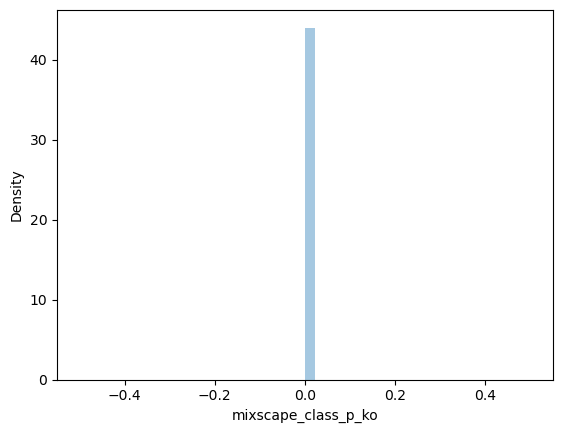

In [29]:
sns.distplot(p_hat)